In [163]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import CanonSmiles
import numpy as np
from itertools import permutations
import random
import json
import csv
import matplotlib.pyplot as plt
import pythoncyc as pc
import requests

In [164]:
def neutralize_atoms(mol):
    pattern = Chem.MolFromSmarts("[+1!h0!$([*]~[-1,-2,-3,-4]),-1!$([*]~[+1,+2,+3,+4])]")
    at_matches = mol.GetSubstructMatches(pattern)
    at_matches_list = [y[0] for y in at_matches]
    if len(at_matches_list) > 0:
        for at_idx in at_matches_list:
            atom = mol.GetAtomWithIdx(at_idx)
            chg = atom.GetFormalCharge()
            hcount = atom.GetTotalNumHs()
            atom.SetFormalCharge(0)
            atom.SetNumExplicitHs(hcount - chg)
            atom.UpdatePropertyCache()
    return mol

## Reaction direction

Fix direction of metacyc reactions

In [2]:
metacyc_rxns_path = 'metacyc_all_reactions_smiles_221214.json'
direction_path = 'reaction_balance_direction_221214.csv'
save_to = 'metacyc_rxns_directed_221214.json'
direction_dict = {}

# Read in all metacyc reactions, not directed correctly
with open(metacyc_rxns_path, 'r') as f:
    mc_rxn_dict = json.load(f)

# Read in reaction directions
with open(direction_path, 'r') as f:
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        if row[0] != 'rxn_id':
            direction_dict[row[0]] = row[2]

# Check the n rxns matches the n directions
n_rxns = len(list(mc_rxn_dict.keys()))
n_directions = len(list(direction_dict.keys()))
print(n_rxns, n_directions)

# Re-direct and save
directed_rxns = {}
ct =0
for k,v in mc_rxn_dict.items():
    this_direct = direction_dict[k]
    if this_direct in ['|PHYSIOL-LEFT-TO-RIGHT|', '|IRREVERSIBLE-LEFT-TO-RIGHT|', '|LEFT-TO-RIGHT|']:
        directed_rxns[k] = [v[0], v[1]]
    elif this_direct in ['|PHYSIOL-RIGHT-TO-LEFT|', '|IRREVERSIBLE-RIGHT-TO-LEFT|', '|RIGHT-TO-LEFT|']:
        directed_rxns[k] = [v[1], v[0]]
    elif this_direct == '|REVERSIBLE|':
        ct += 1
        directed_rxns[k] = [v[0], v[1]]
        directed_rxns[k[:-1] + '_REV|'] = [v[1], v[0]]
    else:
        directed_rxns[k] = [v[0], v[1]]


# Save reaction dict
with open(save_to, 'w') as f:
    json.dump(directed_rxns, f)

19597 19597


Save random subset of reactions

In [4]:
k = 50 # How many rxns to choose
seed = 1234 # Random seed
save_to = f"{k}_random_metacyc_rxns_seed_{seed}.json"

random.seed(seed)
rxn_ids = random.choices(list(directed_rxns.keys()), k=k)

subset_rxns = {key:directed_rxns[key] for key in rxn_ids}

# Save reaction dict
with open(save_to, 'w') as f:
    json.dump(subset_rxns, f)

## Missing smiles

Hunt down SMILES parsing issue

In [27]:
# Bring over sanitize function from mappinng pipeline
def sanitize(list_of_smiles):
    sanitized_smiles = []
    problems = []
    missing_smiles = False
    for elt in list_of_smiles:
        if elt is None:
            missing_smiles = True

        try:
            temp_mol = Chem.MolFromSmiles(elt)
            Chem.rdmolops.RemoveStereochemistry(temp_mol)
            sanitized_smiles.append(Chem.MolToSmiles(temp_mol))
        except:
            try:
                temp_mol = Chem.MolFromSmiles(elt, sanitize=False)
                Chem.rdmolops.RemoveStereochemistry(temp_mol)
                sanitized_smiles.append(Chem.MolToSmiles(temp_mol))
            except:
                problems.append(elt)
    
    return sanitized_smiles, problems, missing_smiles

# Read in subset of mc
subset_path = '200_random_metacyc_rxns_seed_1234.json'
with open(subset_path, 'r') as f:
    subset_rxns = json.load(f)


pre_reactants_cts, pre_products_cts = [], []
post_reactants_cts, post_products_cts = [], []
not_problems = []
problems = []
rxns_missing_smiles = []
for k,rxn in subset_rxns.items():
    reactants, products = list(rxn[0].values()), list(rxn[1].values())

    # Count substrates before sanitation
    pre_reactants_cts.append(len(reactants))
    pre_products_cts.append(len(products))

    # Try to sanitize reactants, track problems
    reactants, this_problems, reactants_missing_smiles = sanitize(reactants) # Remove stereochem
    not_problems += reactants
    problems += this_problems

    # Try to sanitize products, track problems
    products, this_problems, products_missing_smiles = sanitize(products) # Remove stereochem
    problems += this_problems
    not_problems += products

    # Count sanitized substrates
    post_reactants_cts.append(len(reactants))
    post_products_cts.append(len(products))

    if (reactants_missing_smiles) or (products_missing_smiles):
        rxns_missing_smiles.append(k)

diff_reactants = [pre_reactants_cts[i] - post_reactants_cts[i] for i in range(len(pre_reactants_cts))]
diff_products = [pre_products_cts[i] - post_products_cts[i] for i in range(len(pre_products_cts))]

diff_reactants = (np.array(diff_reactants) != 0).sum()
diff_products = (np.array(diff_products) != 0).sum()



RDKit WARNING: [14:48:32] WARNING: not removing hydrogen atom without neighbors
RDKit ERROR: [14:48:32] SMILES Parse Error: syntax error while parsing: C([R])(=O)C([O-])=O
RDKit ERROR: [14:48:32] SMILES Parse Error: Failed parsing SMILES 'C([R])(=O)C([O-])=O' for input: 'C([R])(=O)C([O-])=O'
RDKit ERROR: [14:48:32] SMILES Parse Error: syntax error while parsing: C([R])(=O)C([O-])=O
RDKit ERROR: [14:48:32] SMILES Parse Error: Failed parsing SMILES 'C([R])(=O)C([O-])=O' for input: 'C([R])(=O)C([O-])=O'
RDKit WARNING: [14:48:32] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [14:48:32] WARNING: not removing hydrogen atom without neighbors
RDKit ERROR: [14:48:32] SMILES Parse Error: syntax error while parsing: [C@@H]([NH3+])([R])C([O-])=O
RDKit ERROR: [14:48:32] SMILES Parse Error: Failed parsing SMILES '[C@@H]([NH3+])([R])C([O-])=O' for input: '[C@@H]([NH3+])([R])C([O-])=O'
RDKit ERROR: [14:48:32] SMILES Parse Error: syntax error while parsing: [C@@H]([NH3+])([R])C([

Break out the smiles / rdkit issues by missing, parse

In [ ]:

map_path = 'temp_mapped_rxns.csv'
missing_smiles_path = 'temp_missing_smiles.csv'
parse_issue_path = 'temp_smiles_parse_issues.csv'

# Read in reaction lists
# Mapped / unmapped
mapped_rxns = []
unmapped_rxns = []
with open(map_path, 'r') as f:
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        if len(row) > 1:
            mapped_rxns.append(row[0])
        else:
            unmapped_rxns.append(row[0])

# Missing smiles
missing_smiles_rxns = []
with open(missing_smiles_path, 'r') as f:
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        missing_smiles_rxns.append(row[0])

# Parse error
parse_issue_rxns = []
with open(parse_issue_path, 'r') as f:
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        parse_issue_rxns.append(row[0])

n_mapped = len(mapped_rxns)
n_unmapped = len(unmapped_rxns)
n_missing = len(missing_smiles_rxns)
n_parse = len(parse_issue_rxns)

print("{} out of {} reactions mapped".format(n_mapped, n_mapped + n_unmapped))
print("{} reactions missing smiles".format(n_missing))
print("{} reactions had smiles parsing issue".format(n_parse))

missing_and_parse = list(set(missing_smiles_rxns) & set(parse_issue_rxns))
mapped_and_missing = list(set(mapped_rxns) & set(missing_smiles_rxns))
mapped_and_parse = list(set(mapped_rxns) & set(parse_issue_rxns))
unmapped_and_missing = list(set(unmapped_rxns) & set(missing_smiles_rxns))
unmapped_and_parse = list(set(unmapped_rxns) & set(parse_issue_rxns))

n_mapped_missing = len(mapped_and_missing)
n_mapped_parse = len(mapped_and_parse)
n_unmapped_missing = len(unmapped_and_missing)
n_unmapped_parse = len(unmapped_and_parse)

print("\n{} out of {} mapped reactions missing smiles".format(n_mapped_missing, n_mapped))
print("{} out of {} mapped reactions w/ parse issues".format(n_mapped_parse, n_mapped))
print("\n{} out of {} unmapped reactions missing smiles".format(n_unmapped_missing, n_unmapped))
print("{} out of {} unmapped reactions w/ parse issues".format(n_unmapped_parse, n_unmapped))

31 out of 199 reactions mapped
46 reactions missing smiles
95 reactions had smiles parsing issue

1 out of 31 mapped reactions missing smiles
3 out of 31 mapped reactions w/ parse issues

45 out of 168 unmapped reactions missing smiles
92 out of 168 unmapped reactions w/ parse issues


Get ranked list of substrates with missing smiles

In [4]:
directed_path = 'metacyc_rxns_directed_221214.json'

# Read in directed metacyc reactions
with open(directed_path, 'r') as f:
    directed_mc = json.load(f)

directed_mc[mapped_and_missing[0]]

[{'|CPD-10537|': 'C[C@@]34([C@H]2(CC[C@]5(C)([C@@H](C1(\\COC(=O)\\C=1))CC[C@](O)([C@@H]2CC[C@@H]3C[C@@H](O)CC4)5)))',
  '|Red-NADPH-Hemoprotein-Reductases|': None,
  '|OXYGEN-MOLECULE|': 'O=O'},
 {'|CPD-22576|': 'C[C@@]45([C@H](CC[C@@H]3([C@H](CC[C@]2(C)([C@@H](C1(\\COC(=O)\\C=1))[C@@H](O)C[C@@](O)23))4))C[C@@H](O)CC5)',
  '|Ox-NADPH-Hemoprotein-Reductases|': None,
  '|WATER|': 'O'}]

1936 unique compounds in metacyc missing smiles


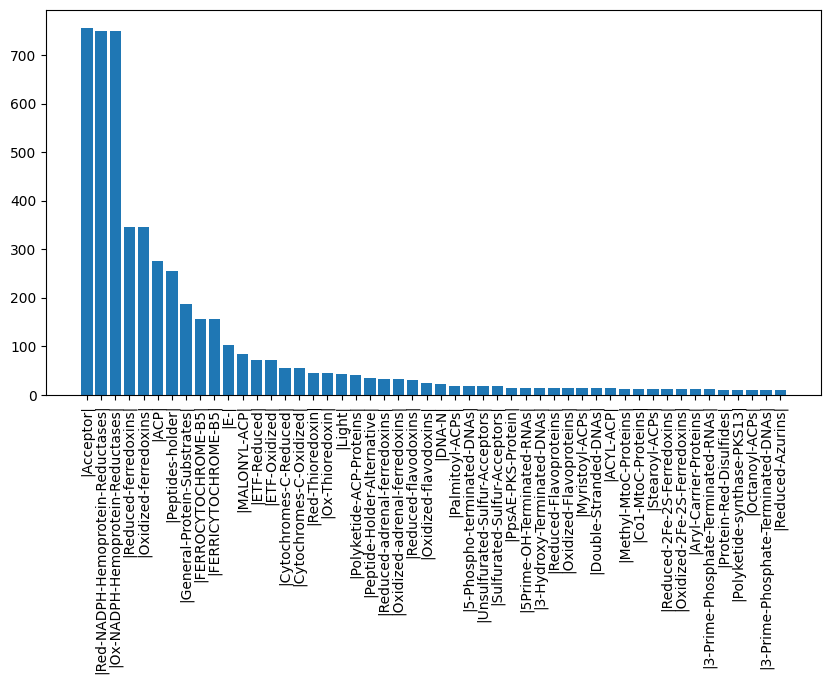

In [5]:
subs_wo_smiles = {}
for k,v in directed_mc.items(): # Over reactions
    for i in range(2): # Over reactant & product dicts
        for k2 in v[i].keys(): # Over cpds in reactant / product dicts
            if (v[i][k2] is None) and (k2 not in subs_wo_smiles.keys()):
                subs_wo_smiles[k2] = 1
            elif (v[i][k2] is None):
                subs_wo_smiles[k2] += 1

subs_wo_smiles = [[elt[1], elt[0]] for elt in sorted(zip(subs_wo_smiles.values(), subs_wo_smiles.keys()), reverse=True)]
n_unique_cpds_missing_smiles = len(subs_wo_smiles)
print("{} unique compounds in metacyc missing smiles".format(n_unique_cpds_missing_smiles))

subs_wo_smiles = np.array(subs_wo_smiles)
upto = 50
fig, ax = plt.subplots(figsize=(10,5))
ax.bar(subs_wo_smiles[:upto,0], subs_wo_smiles[:upto,1].astype(float))
ax.set_xticks(subs_wo_smiles[:upto,0])
ax.set_xticklabels(subs_wo_smiles[:upto,0], rotation=90)
plt.show()


In [32]:
subs_wo_smiles[:upto,1].astype(float)

array([756., 749., 749., 346., 346., 275., 255., 187., 155., 155., 103.,
        84.,  71.,  71.,  54.,  54.,  45.,  45.,  43.,  40.,  35.,  32.,
        32.,  31.,  23.,  22.,  18.,  18.,  17.,  17.,  14.,  14.,  14.,
        13.,  13.,  13.,  13.,  13.,  12.,  12.,  11.,  11.,  11.,  11.,
        11.,  10.,  10.,  10.,  10.,   9.])

Throw out metacyc reactions w/o smiles and save smaller list

In [6]:
mc_smiles_only = {}
for k,v in directed_mc.items(): # Over reactions
    is_missing = False
    for i in range(2): # Over reactant & product dicts
        for k2 in v[i].keys(): # Over cpds in reactant / product dicts
            if v[i][k2] is None:
                is_missing = True
                break

        if is_missing:
            break

    if not is_missing:
        mc_smiles_only[k] = v

# Save reaction dict
save_to = 'metacyc_rxns_directed_containing_smiles_221214.json'
with open(save_to, 'w') as f:
    json.dump(mc_smiles_only, f)


In [7]:
len(list(mc_smiles_only.keys())) / len(list(directed_mc.keys()))

0.7793211339717455

Save random subset of smiles-only metacyc

In [8]:
k = 100 # How many rxns to choose
seed = 1234 # Random seed
save_to = f"{k}_random_metacyc_rxns_smiles_only_seed_{seed}.json"

random.seed(seed)
rxn_ids = random.choices(list(mc_smiles_only.keys()), k=k)

subset_rxns = {key:mc_smiles_only[key] for key in rxn_ids}

# Save reaction dict
with open(save_to, 'w') as f:
    json.dump(subset_rxns, f)

## Smiles parsing issues

Load reaction test subset with no missing smiles, break out mapping, parsing issues

In [2]:
map_path = 'smiles_only_mapped_rxns.csv'
missing_smiles_path = 'smiles_only_missing_smiles.csv'
parse_issue_path = 'smiles_only_smiles_parse_issues.csv'

# Read in reaction lists
# Mapped / unmapped
mapped_rxns = []
unmapped_rxns = []
with open(map_path, 'r') as f:
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        if len(row) > 1:
            mapped_rxns.append(row[0])
        else:
            unmapped_rxns.append(row[0])

# Missing smiles
missing_smiles_rxns = []
with open(missing_smiles_path, 'r') as f:
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        missing_smiles_rxns.append(row[0])

# Parse error
parse_issue_rxns = []
with open(parse_issue_path, 'r') as f:
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        parse_issue_rxns.append(row[0])

n_mapped = len(mapped_rxns)
n_unmapped = len(unmapped_rxns)
n_missing = len(missing_smiles_rxns)
n_parse = len(parse_issue_rxns)

print("{} out of {} reactions mapped".format(n_mapped, n_mapped + n_unmapped))
print("{} reactions missing smiles".format(n_missing))
print("{} reactions had smiles parsing issue".format(n_parse))

missing_and_parse = list(set(missing_smiles_rxns) & set(parse_issue_rxns))
mapped_and_missing = list(set(mapped_rxns) & set(missing_smiles_rxns))
mapped_and_parse = list(set(mapped_rxns) & set(parse_issue_rxns))
unmapped_and_missing = list(set(unmapped_rxns) & set(missing_smiles_rxns))
unmapped_and_parse = list(set(unmapped_rxns) & set(parse_issue_rxns))

n_mapped_missing = len(mapped_and_missing)
n_mapped_parse = len(mapped_and_parse)
n_unmapped_missing = len(unmapped_and_missing)
n_unmapped_parse = len(unmapped_and_parse)

print("\n{} out of {} mapped reactions missing smiles".format(n_mapped_missing, n_mapped))
print("{} out of {} mapped reactions w/ parse issues".format(n_mapped_parse, n_mapped))
print("\n{} out of {} unmapped reactions missing smiles".format(n_unmapped_missing, n_unmapped))
print("{} out of {} unmapped reactions w/ parse issues".format(n_unmapped_parse, n_unmapped))

20 out of 99 reactions mapped
0 reactions missing smiles
55 reactions had smiles parsing issue

0 out of 20 mapped reactions missing smiles
1 out of 20 mapped reactions w/ parse issues

0 out of 79 unmapped reactions missing smiles
54 out of 79 unmapped reactions w/ parse issues


Inspect problematic smiles

In [4]:
# Load in all metacyc reactions w/o missing smiles
mc_smiles_only_path = 'metacyc_rxns_directed_containing_smiles_221214.json'

with open(mc_smiles_only_path, 'r') as f:
    mc_smiles_only = json.load(f)

save_problem_compounds = 'cpds_smiles_cause_rdkit_problems.csv'

problem_cpds = []
for rxn_id in parse_issue_rxns:
    for i in range(2):
        for k,v in mc_smiles_only[rxn_id][i].items():
            temp_mol = Chem.MolFromSmiles(v)
            if temp_mol is None:
                if [k, v] not in problem_cpds:
                    problem_cpds.append([k, v])

with open(save_problem_compounds, 'w') as f:
    writer = csv.writer(f)
    writer.writerows(problem_cpds)

RDKit ERROR: [15:05:05] SMILES Parse Error: syntax error while parsing: C(O)[C@@H](O)COP(O[R])(=O)[O-]
RDKit ERROR: [15:05:05] SMILES Parse Error: Failed parsing SMILES 'C(O)[C@@H](O)COP(O[R])(=O)[O-]' for input: 'C(O)[C@@H](O)COP(O[R])(=O)[O-]'
RDKit ERROR: [15:05:05] SMILES Parse Error: syntax error while parsing: C([C@@H]1([C@H]([C@@H]([C@H]([C@@H](O1)O[R])O)O)O))O[C@H]2([C@@H]([C@H]([C@@H]([C@H](O2)CO)O)O)O[C@H]3([C@@H]([C@H]([C@@H]([C@H](O3)CO)O)O)O))
RDKit ERROR: [15:05:05] SMILES Parse Error: Failed parsing SMILES 'C([C@@H]1([C@H]([C@@H]([C@H]([C@@H](O1)O[R])O)O)O))O[C@H]2([C@@H]([C@H]([C@@H]([C@H](O2)CO)O)O)O[C@H]3([C@@H]([C@H]([C@@H]([C@H](O3)CO)O)O)O))' for input: 'C([C@@H]1([C@H]([C@@H]([C@H]([C@@H](O1)O[R])O)O)O))O[C@H]2([C@@H]([C@H]([C@@H]([C@H](O2)CO)O)O)O[C@H]3([C@@H]([C@H]([C@@H]([C@H](O3)CO)O)O)O))'
RDKit ERROR: [15:05:05] SMILES Parse Error: syntax error while parsing: C(O)[C@H]7(O[C@@H](O[R2])[C@H](O[C@@H]6(O[C@H](CO)[C@@H](O)[C@H](O)[C@@H](O[C@H]5([C@H](O[C@@H]4(O[C

O)=1)[C@@H]5(O[C@H](COP(=O)([O-])OP(=O)([O-])OC[C@H]2(O[C@H]([C@H](O[R])[C@H](O)2)N3(\C=N/C4(C(/N)=N\C=N/C3=4))))[C@@H](O)[C@@H](O)5))'
[15:05:05] WARNING: not removing hydrogen atom without neighbors
[15:05:05] SMILES Parse Error: syntax error while parsing: C5(/C=C\C(\C(=O)N)=C/[N+](/[C@@H]1(O[C@@H]([C@H]([C@H]1O)O)COP(OP(OC[C@H]4(O[C@@H](N2(C3(\C(\N=C/2)=C(N)/N=C\N=3)))[C@H](O[R])[C@H](O)4))(=O)[O-])(=O)[O-]))=5)
[15:05:05] SMILES Parse Error: Failed parsing SMILES 'C5(/C=C\C(\C(=O)N)=C/[N+](/[C@@H]1(O[C@@H]([C@H]([C@H]1O)O)COP(OP(OC[C@H]4(O[C@@H](N2(C3(\C(\N=C/2)=C(N)/N=C\N=3)))[C@H](O[R])[C@H](O)4))(=O)[O-])(=O)[O-]))=5)' for input: 'C5(/C=C\C(\C(=O)N)=C/[N+](/[C@@H]1(O[C@@H]([C@H]([C@H]1O)O)COP(OP(OC[C@H]4(O[C@@H](N2(C3(\C(\N=C/2)=C(N)/N=C\N=3)))[C@H](O[R])[C@H](O)4))(=O)[O-])(=O)[O-]))=5)'
[15:05:05] SMILES Parse Error: syntax error while parsing: C(O)[C@H]1(O[C@@H]([C@H](O)[C@@H](O)[C@H](O[R1])1)O[C@H]4([C@H](O)[C@@H](O)[C@@H](O[C@H]2([C@H](O)[C@@H](O)[C@H](O[C@H](CO)2)O[C@H]3(

## 

## Fix metacyc smiles issues with other databases

### Try brenda and joseph's brenda_neutralize tsv first

Get compound names for all metacyc reactions via pythoncyc. Search brenda tsv for that entry

In [104]:
directed_path = 'metacyc_rxns_directed_221214.json'

# Read in all metacyc reactions, not directed correctly
with open(directed_path, 'r') as f:
    directed_rxns = json.load(f)

# Load in substrate entries from pc
meta = pc.so('meta')

# Get compound names for every reaction substrate
cpd_names = {}
for k,v in directed_rxns.items(): # Over reactions
    for i in range(2): # Over reactant & product dicts
        for k2 in v[i].keys(): # Over cpds in reactant / product dicts
            if k2 not in cpd_names.keys():
                cpd_names[k2] = meta[k2].names


In [105]:
n_cpds_mc = len(list(cpd_names.keys()))
brenda_path = 'brenda_neutralize.tsv'

# Load in brenda
brenda_cpd_smi = {}
with open(brenda_path, 'r') as f:
    reader = csv.reader(f, delimiter='\t')
    for row in reader:
        brenda_cpd_smi[row[0].lower()] = row[1]

mc_id_2_brenda_name = {}
for k,v in cpd_names.items():
    for elt in v:
        if elt.lower() in brenda_cpd_smi.keys():
            mc_id_2_brenda_name[k] = elt.lower()

len(list(mc_id_2_brenda_name.keys())) / len(list(cpd_names.keys()))

0.2561086521554599

In [106]:
# Save mc id to brenda name
save_to = 'metacyc_id_to_brenda_name.json'
with open(save_to, 'w') as f:
    json.dump(mc_id_2_brenda_name, f)

### Try modelSEED next

In [107]:
seed_path = 'modelseed_cpds_230710.json'

# Load in seed dataset
with open(seed_path, 'r') as f:
    seed_dict = json.load(f)

Search by metacyc alias first, name / synonyms after

In [108]:
# Make a dict of seed id to lowercased aliases (metacyc alias, names, synonyms, etc)
seed_id_to_aliases = {}
for k,v in seed_dict.items():
    new_aliases = []
    if 'aliases' in v.keys():
        aliases = v['aliases']
        
        for elt in aliases:
            if 'Metacyc' in elt:
                temp = elt.split(': ')[-1].split('; ')
                mc_aliases = [elt2.lower() for elt2 in temp]
                new_aliases += mc_aliases

            if 'Name' in elt:
                temp = elt.split(': ')[-1].split('; ')
                name_aliases = [elt2.lower() for elt2 in temp]
                new_aliases += name_aliases

    else:
        new_aliases.append(v['name'].lower())
        new_aliases.append(v['abbreviation'].lower())

    seed_id_to_aliases[k]= new_aliases

# Search for metacyc cpds in the seed database
# and construct mc id to seed id dict
mc_id_2_seed_id = {}
for k,v in cpd_names.items():# Iterate over metacyc compounds
    format_k = k[0:-1].lower()
    for k2, v2 in seed_id_to_aliases.items():# Iterate over seed id -> keywords dict
        
        # Search using mc id first
        if format_k in v2:
            mc_id_2_seed_id[k] = k2 # Associate mc id with seed id
        else: # Search by every name assoc w mc cpd
            for elt in v:
                if elt.lower() in v2:
                    mc_id_2_seed_id[k] = k2


KeyboardInterrupt: 

In [101]:
# Save mc id to seed id
save_to = 'metacyc_id_to_seed_id.json'
with open(save_to, 'w') as f:
    json.dump(mc_id_2_seed_id, f)

In [100]:
len(list(mc_id_2_seed_id.keys())) / len(list(cpd_names.keys()))

0.46947189716849574

Append as many SEED compounds to Jos list as possible

In [128]:
save_to = 'seed_id_to_smiles.json'

# Load jos seed cpd id to smiles list
jos_seed_path = 'SEED_neutralized.tsv'
jos_seed = {}
with open(jos_seed_path, 'r') as f:
    reader = csv.reader(f, delimiter='\t')
    for row in reader:
        if row[0] != 'cpd':
            jos_seed[row[0]] = row[1]

# Get all the id to smiles mappings possible from current SEED
current_seed_id_2_smiles = {}
for k,v in seed_dict.items():
    if 'smiles' in v.keys():
        this_smi = v['smiles']
        this_mol = Chem.MolFromSmiles(this_smi)
        
        # Try to neutralize molecule
        if this_mol is not None: # avoid issues with MolFromSmiles
            try:
                this_neutral_mol = neutralize_atoms(this_mol) # Neutralize molecules
                this_neutral_smi = Chem.MolToSmiles(this_neutral_mol)
            except: # rdkit errors
                this_neutral_smi = this_smi
        else:
            this_neutral_smi = this_smi
        current_seed_id_2_smiles[k] = this_neutral_smi

# Overwrite with jos where possible, his preferred
for k,v in jos_seed.items():
    current_seed_id_2_smiles[k] = v

print(len(list(jos_seed.keys())))
print(len(list(current_seed_id_2_smiles.keys())))

# save
with open(save_to, 'w') as f:
    json.dump(current_seed_id_2_smiles, f)

RDKit WARNING: [16:49:11] WARNING: not removing hydrogen atom without neighbors
[16:49:11] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [16:49:15] Conflicting single bond directions around double bond at index 1.
RDKit WARNING: [16:49:15]   BondStereo set to STEREONONE and single bond directions set to NONE.
[16:49:15] Conflicting single bond directions around double bond at index 1.
[16:49:15]   BondStereo set to STEREONONE and single bond directions set to NONE.
RDKit WARNING: [16:49:15] Conflicting single bond directions around double bond at index 1.
RDKit WARNING: [16:49:15]   BondStereo set to STEREONONE and single bond directions set to NONE.
[16:49:15] Conflicting single bond directions around double bond at index 1.
[16:49:15]   BondStereo set to STEREONONE and single bond directions set to NONE.
RDKit ERROR: [16:49:16] Explicit valence for atom # 11 B, 7, is greater than permitted
[16:49:16] Explicit valence for atom # 11 B, 7, is greater than permitte

28017
28123


Figure out how many of the missing and troublesome SMILES you have replacements for from SEED & BRENDA and update the metacyc reaction dict with these new SMILES entries

In [129]:
mc2seed_path = 'metacyc_id_to_seed_id.json'
mc2brenda_path = 'metacyc_id_to_brenda_name.json'
seed2smi_path = 'seed_id_to_smiles.json'
brenda2smi_path = 'brenda_neutralize.tsv'
directed_path = 'metacyc_rxns_directed_221214.json'

# Load mc id to seed id
with open(mc2seed_path, 'r') as f:
    mc2seed = json.load(f)

# Load mc id to brenda name
with open(mc2brenda_path, 'r') as f:
    mc2brenda = json.load(f)

# Load seed id to smiles
with open(seed2smi_path, 'r') as f:
    seed2smi = json.load(f)

# Load brenda name to smiles
brenda2smi = {}
with open(brenda2smi_path, 'r') as f:
    reader = csv.reader(f, delimiter='\t')
    for row in reader:
        if row[0] != 'cpd':
            brenda2smi[row[0]] = row[1]

# Load directed metacyc reactions
with open(directed_path, 'r') as f:
    directed_rxns = json.load(f)

# Load lists of rxns w/ cpds missing or triggering rdkit parse issues
# (were run in .py bc of rdkit issue in .ipynb)
labels = ['cpds_missing', 'rxns_missing', 'cpds_parse', 'rxns_parse']
datas = []
for i in range(len(labels)):
    load_from = f"metacyc_{labels[i]}_smiles.csv"
    with open(load_from, 'r') as f:
        reader = csv.reader(f, delimiter=',')
        temp = []
        for row in reader:
            temp.append(row[0])
    
    datas.append(temp)

cpds_missing_smiles, rxns_w_cpds_missing_smiles, cpds_parse_issues, rxns_w_cpds_parse_issues = datas

In [130]:
# How many troublesome did you get replacements for

solved_missing = list(set(cpds_missing_smiles) & (set(mc2seed.keys()) | set(mc2brenda.keys())))
solved_parse = list(set(cpds_parse_issues) & (set(mc2seed.keys()) | set(mc2brenda.keys())))
print("Solved {} / {} missing smiles".format(len(solved_missing), len(cpds_missing_smiles)))
print("Solved {} / {} parse issues".format(len(solved_parse), len(cpds_parse_issues)))

# Replace the smiles you can in reaction dict
all_problem_rxns = list(set(rxns_w_cpds_missing_smiles) | set(rxns_w_cpds_parse_issues))
directed_rxns_updated_smiles = directed_rxns.copy()
for elt in all_problem_rxns:
    for i in range(2):
        for k,_ in directed_rxns_updated_smiles[elt][i].items(): # Iterate over id:smi pairs in reac/prod
            if (k in mc2seed.keys()) and (mc2seed[k] in seed2smi.keys()):
                directed_rxns_updated_smiles[elt][i][k] = seed2smi[mc2seed[k]]
            elif (k in mc2brenda.keys()) and (mc2brenda[k] in brenda2smi.keys()):
                directed_rxns_updated_smiles[elt][i][k] = brenda2smi[mc2brenda[k]]

# Save mc reactions with smiles entries updated BUT still has some problem smiles
save_to = 'metacyc_directed_rxns_updated_smiles_221214.json'
with open(save_to, 'w') as f:
    json.dump(directed_rxns_updated_smiles, f)

Solved 681 / 1936 missing smiles
Solved 2154 / 6369 parse issues


Check the fraction of trouble-less reactions you have with rdkit

In [131]:
# Load lists of missing and parse issues before and after update
labels = ['rxns_missing', 'rxns_parse']
path_suffixes = ['_smiles.csv', '_smiles_post_update.csv']

datas = []
for j in range(2):
    for i in range(len(labels)):
        load_from = f"metacyc_{labels[i]}" + path_suffixes[j]
        with open(load_from, 'r') as f:
            reader = csv.reader(f, delimiter=',')
            temp = []
            for row in reader:
                temp.append(row[0])
        
        datas.append(temp)

pre_missing, pre_parse, post_missing, post_parse  = datas
pre_problems = list(set(pre_missing) | set(pre_parse))
post_problems = list(set(post_missing) | set(post_parse))
print("{} reactions with missing smiles post update comp. to {}".format(len(post_missing), len(pre_missing)))
print("{} reactions with parse issues post update comp. to {}".format(len(post_parse), len(pre_parse)))
print("{} total reactions with problems comp. to {}".format(len(post_problems), len(pre_problems)))
print("out of {} total reactions".format(len(directed_rxns.keys())))
print(len(directed_rxns.keys()) - len(post_problems), "reactions are good")

4573 reactions with missing smiles post update comp. to 4655
7945 reactions with parse issues post update comp. to 11886
10783 total reactions with problems comp. to 14348
out of 21094 total reactions
10311 reactions are good


In [140]:
# Filter out problems and save


# Load updated reaction dict (still has some troublesome smiles)
updated_rxns_path = 'metacyc_directed_rxns_updated_smiles_221214.json'
with open(updated_rxns_path, 'r') as f:
    updated_rxns = json.load(f)

mc_rxns_problems_filtered_out = {}
for k,v in updated_rxns.items():
    if k == '|RXN-16269|':
        print(v)
    if k not in post_problems:
        mc_rxns_problems_filtered_out[k] = v

# Save the metacyc reactions free of problems
save_to = 'metacyc_rxns_directed_filtered_out_problem_smiles_221214.json'
with open(save_to, 'w') as f:
    json.dump(mc_rxns_problems_filtered_out, f)

[{'|CPD-17515|': 'CC(C)(COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)(O)O)[C@@H](O)C(=O)NCCC(=O)NCCSC(=O)Cc1cc(O)cc(O)c1', '|OXYGEN-MOLECULE|': 'O=O'}, {'|CPD-15753|': '*C(=O)C(=O)O', '|CO-A|': 'CC(C)(COP([O-])(=O)OP(OC[C@H]3(O[C@@H](N1(C2(\\N=C/N=C(C(\\N=C/1)=2)/N)))[C@H](O)[C@H](OP([O-])(=O)[O-])3))(=O)[O-])[C@@H](O)C(=O)NCCC(=O)NCCS', '|PROTON|': '[H+]'}]


In [122]:
k = 50 # How many rxns to choose
seed = 1234 # Random seed
save_to = f"{k}_random_metacyc_rxns_filtered_rnd_seed_{seed}.json"

random.seed(seed)
rxn_ids = random.choices(list(mc_rxns_problems_filtered_out.keys()), k=k)

subset_rxns = {key:mc_rxns_problems_filtered_out[key] for key in rxn_ids}

# Save reaction dict
with open(save_to, 'w') as f:
    json.dump(subset_rxns, f)

In [69]:
cl_smi = '[Cl-]'
cl_mol = Chem.MolFromSmiles(cl_smi)
cl_neutral_mol = neutralize_atoms(cl_mol)
cl_neutral_smi = Chem.MolToSmiles(cl_neutral_mol)

nad_smi = 'NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)([O-])OP(=O)([O-])OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1'
nad_mol = Chem.MolFromSmiles(nad_smi)
nad_neutral_mol = neutralize_atoms(nad_mol)
nad_neutral_smi = Chem.MolToSmiles(nad_neutral_mol)
nad_neutral_smi, '\n', nad_smi

('NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1',
 '\n',
 'NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)([O-])OP(=O)([O-])OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1')

## Pull modelSEED compounds and save to json

In [ ]:
n_entries = 33995 # Total number of compounds on seed as of 11/15/2022
seed_cpds_url = f"https://modelseed.org/solr/compounds/select?wt=json&fl=name,id,formula,mass,abbreviation,deltag,deltagerr,charge,aliases,smiles,ontology&q=*&rows={n_entries}&sort=id%20asc"
save_to = 'modelseed_cpds_230710.json'

# Get JSON object from model SEED
json_obj = requests.get(seed_cpds_url).json()
seed_cpds = json_obj['response']['docs'] # This comes down as a list of dicts

# Make list of dicts into dict of dicts using 
# modelSEED ids as keys
seed_dict = {}
for elt in seed_cpds:
    seed_dict[elt['id']] = elt
    
# Save seed dict
with open(save_to, 'w') as f:
    json.dump(seed_dict, f)


## Stoichiometry, reaction balancing

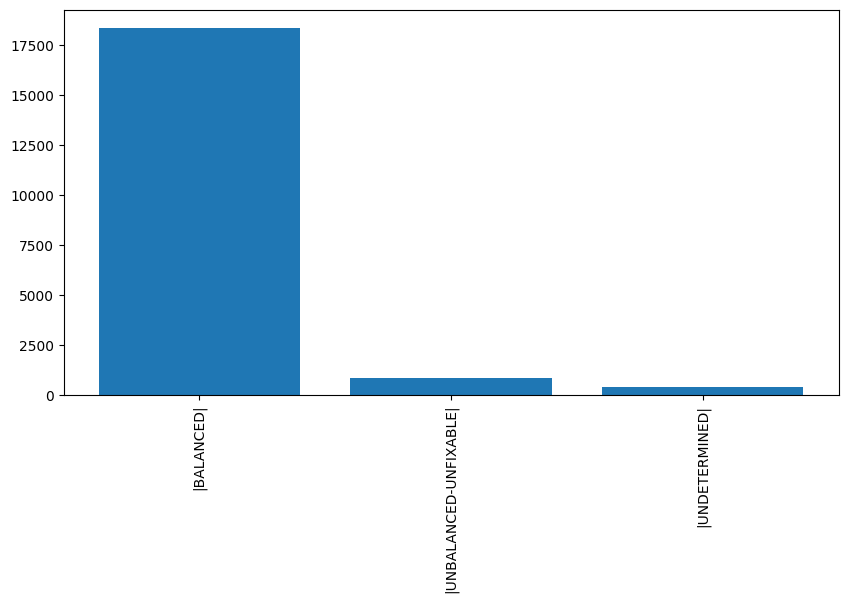

{'|BALANCED|': 18361, '|UNBALANCED-UNFIXABLE|': 851, '|UNDETERMINED|': 385}

In [91]:
direction_path = 'reaction_balance_direction_221214.csv'

direction_dict = {}
# Read in reaction directions
with open(direction_path, 'r') as f:
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        if row[0] != 'rxn_id':
            direction_dict[row[0]] = row[1]


type_dir = {} # Type of entry in direction slot
for k,v in direction_dict.items():
    if v not in type_dir.keys():
        type_dir[v] = 1
    else:
        type_dir[v] += 1

dir_labels = list(type_dir.keys())
dir_label_cts = list(type_dir.values())
fig, ax = plt.subplots(figsize=(10,5))
ax.bar(dir_labels, dir_label_cts)
ax.set_xticks(dir_labels)
ax.set_xticklabels(dir_labels, rotation=90)
plt.show()

type_dir

In [97]:
# rxn-17984 example of stoich off
# rxn-

directed_rxns['|RXN-17984|']

([{'|CPD-17515|': 'CC(C)([C@@H](O)C(=O)NCCC(=O)NCCSC(CC1(\\C=C(/C=C(\\C=1)/O)\\O))=O)COP(=O)(OP(=O)(OC[C@@H]2([C@@H](OP([O-])(=O)[O-])[C@@H](O)[C@@H](O2)N3(C4(\\N=C/N=C(C(\\N=C/3)=4)/N))))[O-])[O-]',
   '|OXYGEN-MOLECULE|': 'O=O'},
  {'|CPD-15753|': 'C([R])(=O)C([O-])=O',
   '|CO-A|': 'CC(C)(COP([O-])(=O)OP(OC[C@H]3(O[C@@H](N1(C2(\\N=C/N=C(C(\\N=C/1)=2)/N)))[C@H](O)[C@H](OP([O-])(=O)[O-])3))(=O)[O-])[C@@H](O)C(=O)NCCC(=O)NCCS',
   '|PROTON|': '[H+]'}],
 [{'|OxyC-monocyclic|': None}, {'|OxyC-tricyclic|': None, '|WATER|': '[O]'}])

In [110]:
rxn = directed_rxns['|RXN-16269|']
for elt in rxn:
    for k in elt.keys():
        if k not in mc2seed.keys():
            print(k)

In [138]:
mc_rxns_problems_filtered_out['|RXN-16269|']

[{'|CPD-17515|': 'CC(C)(COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)(O)O)[C@@H](O)C(=O)NCCC(=O)NCCSC(=O)Cc1cc(O)cc(O)c1',
  '|OXYGEN-MOLECULE|': 'O=O'},
 {'|CPD-15753|': '*C(=O)C(=O)O',
  '|CO-A|': 'CC(C)(COP([O-])(=O)OP(OC[C@H]3(O[C@@H](N1(C2(\\N=C/N=C(C(\\N=C/1)=2)/N)))[C@H](O)[C@H](OP([O-])(=O)[O-])3))(=O)[O-])[C@@H](O)C(=O)NCCC(=O)NCCS',
  '|PROTON|': '[H+]'}]

In [125]:
coa = 'CC(C)(COP([O-])(=O)OP(OC[C@H]3(O[C@@H](N1(C2(\\N=C/N=C(C(\\N=C/1)=2)/N)))[C@H](O)[C@H](OP([O-])(=O)[O-])3))(=O)[O-])[C@@H](O)C(=O)NCCC(=O)NCCS'
coa_mol = Chem.MolFromSmiles(coa)
coa_mol = neutralize_atoms(coa_mol)
coa_smi = Chem.MolToSmiles(coa_mol)
coa_smi

'CC(C)(COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)(O)O)[C@@H](O)C(=O)NCCC(=O)NCCS'

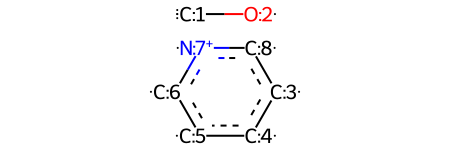

In [146]:
Chem.MolFromSmiles('[#6:1]-[#8:2].[#6:3]1:[#6:4]:[#6:5]:[#6:6]:[#7+:7]:[#6:8]:1')

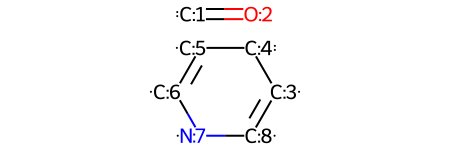

In [147]:
Chem.MolFromSmiles('[#6:3]1=[#6:8]-[#7+0:7]-[#6:6]=[#6:5]-[#6:4]-1.[#6:1]=[#8:2]')

RDKit WARNING: [10:15:44] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [10:15:44] unsupported number of radical electrons 4
[10:15:44] WARNING: not removing hydrogen atom without neighbors
[10:15:44] unsupported number of radical electrons 4


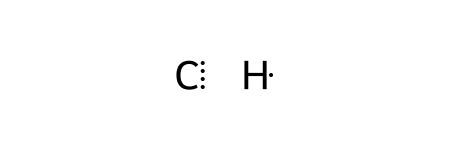

In [154]:
Chem.MolFromSmiles('[#6].[#1]')

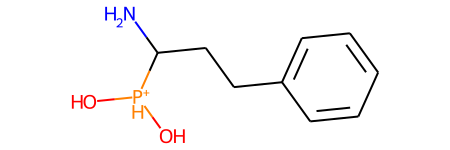

In [155]:
Chem.MolFromSmiles('NC(CCc1ccccc1)[PH+](O)O')

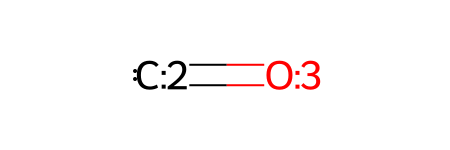

In [157]:
Chem.MolFromSmiles('[#6:2]=[#8:3]')

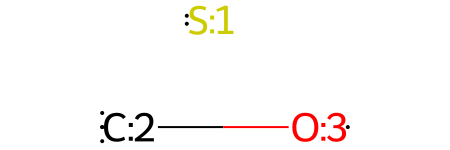

In [158]:
Chem.MolFromSmiles('[#16:1].[#6:2]-[#8:3]')

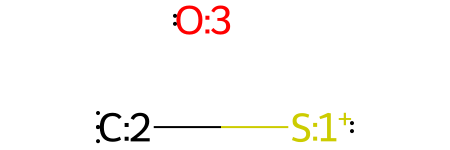

In [159]:
Chem.MolFromSmiles('[#6:2]-[#16+:1].[#8:3]')

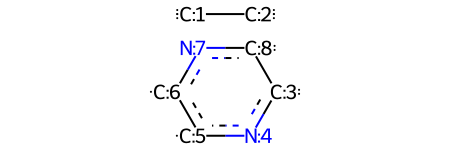

In [160]:
Chem.MolFromSmiles('[#6:1]-[#6:2].[#6:3]1:[#7:4]:[#6:5]:[#6:6]:[#7:7]:[#6:8]-1')

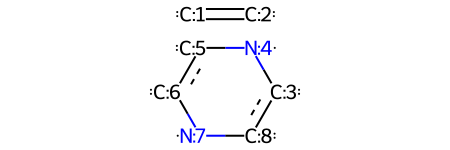

In [162]:
Chem.MolFromSmiles('[#6:3]1:[#6:8]-[#7:7]-[#6:6]:[#6:5]-[#7:4]-1.[#6:1]=[#6:2]')